In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector
import scipy.stats as stats

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

In [2]:
reviews_path_ba = "data/matched_beer_data/ratings_ba.txt"
reviews_path_rb = "data/matched_beer_data/ratings_rb.txt"
users_path_ba = "data/users_ba.csv"
users_path_rb = "data/users_rb.csv"
breweries_path = "data/matched_beer_data/breweries.csv"
beers_path = "data/matched_beer_data/beers.csv"

In [3]:
states_climate = pd.read_csv("data/states_climate.csv")
states_climate.set_index("State", inplace=True)

In [25]:
climate_classifications = pd.read_csv("data/climate_classified.csv")
climate_classifications.set_index("climate", inplace=True)

climate_classifications.head(10)

,scheme,seasonal_precipitation,heat_level
climate,,,
Cfa,Temperate,without dry season,hot summer
Dfb,Continental,without dry season,warm summer
Dfa,Continental,without dry season,hot summer
Csa,Temperate,with dry season,hot summer
Dsb,Continental,with dry season,warm summer
Dfc,Continental,without dry season,cold summer
Csb,Temperate,with dry season,warm summer
Bsk,Dry,with dry season,cold summer
Cfb,Temperate,without dry season,warm summer


In [4]:
# Load the data

users_df_ba = get_users_df(users_path_ba)
users_df_rb = get_users_df(users_path_rb)
ba_df = get_reviews_df(reviews_path_ba)
rb_df = get_reviews_df(reviews_path_rb)
breweries_df = get_breweries_df(breweries_path)
beers_df = get_beers_df(beers_path)
beers_df = join_breweries_on_beers(beers_df, breweries_df)
reviews_df = merge_reviews(ba_df, rb_df, beers_df, users_df_ba, users_df_rb)

In [14]:
# Focus on the US only

pd.set_option("display.max_columns", None)

world_ratings = reviews_df.copy()
world_ratings["nbr_ratings"] = world_ratings["nbr_ratings_rb"] + world_ratings["nbr_ratings_ba"]

#drop rows where user_location is NaN   
world_ratings = world_ratings.dropna()

#create df with only users from the us
us_users_ratings = world_ratings[world_ratings["user_location"].str.contains("United States")]
us_users_ratings = us_users_ratings.T.drop_duplicates().T

#convert ratings from string to float
columns_compare = ["aroma", "appearance", "palate", "taste", "overall", "rating"]
us_users_ratings[columns_compare] = us_users_ratings[columns_compare].astype(float)

us_users_ratings["user_location"] = [name.replace("United States, ", "") for name in us_users_ratings["user_location"]]

#add climate column where climate is the climate of the state the user is from
us_users_ratings["climate"] = us_users_ratings["user_location"].map(states_climate["Climate"])

In [26]:
us_users_ratings["climate_scheme"] = us_users_ratings["climate"].map(climate_classifications["scheme"])
us_users_ratings["climate_precipitation"] = us_users_ratings["climate"].map(climate_classifications["seasonal_precipitation"])
us_users_ratings["climate_temperature"] = us_users_ratings["climate"].map(climate_classifications["heat_level"])

## 1. How does the climate of a user impact their preference in beer style?

1. What type of beer do users from each climate prefer? Is there significance?
2. What is the most rated beer from each climate? Is it one they dislike or like strongly?
3. Is the alcohol percentage of the preferred beer significant to the respective climates?

First, we will need to preprocess the `us_users_ratings` dataset to add a `general_style` column that is made from the beer's `style` which can be very specific. Then, we need to group the beers by climate to do the analysis to find answers to our questions.  

In [15]:
us_users_ratings.head()

,beer_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,abv,beer_avg_rating_ba,beer_name,brewery_id_ba,nbr_ratings_ba,beer_avg_rating_rb,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location,brewery_name,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate
7,19827,English Pale Ale,1360753200,brewdude1982,brewdude1982.691169,4.25,4.50,3.25,3.75,3.75,3.91,This was a 12 oz bottle poured into a snifter....,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,North Carolina,264.0,164,Cfa
8,19827,English Pale Ale,1357729200,AgentMunky,agentmunky.409755,4.00,3.75,3.50,3.50,3.75,3.64,Poured from a 12 ounce bottle into a pilsner g...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,New York,2314.0,164,Cfa
12,19827,English Pale Ale,1353150000,ferrari29,ferrari29.320392,3.00,3.50,2.50,2.50,2.50,2.77,Beer poured from bottle into a Nonic shaped pi...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,Illinois,585.0,164,Dfa
14,19827,English Pale Ale,1342260000,OtherShoe2,othershoe2.233642,4.00,3.50,4.00,3.50,4.00,3.68,Pours a rich brownish red with some chill haze...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,Massachusetts,1315.0,164,Dfa
16,19827,English Pale Ale,1335607200,brentk56,brentk56.6284,4.50,3.00,3.50,2.50,2.50,2.84,Appearance: These Strangford Lough beers pour ...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,North Carolina,6306.0,164,Cfa


As there are many different styles of beer, it seems too hard to automate the process of tokenisation. We chose to export the dataframe with the style of beer and manually assign each one to a more general style. The groupings were made based on this reference: https://hospitalityinsights.ehl.edu/beer-types. These are:
- Lager
- Pale Ale
- Blonde Ale
- Brown Ale
- IPA
- Wheatbeer
- Porter
- Stout
- Sour Ale
- Scottish Ale

In [16]:
# get all styles of beers to regroup them by general types 

beer_styles = us_users_ratings[['style']].copy()
beer_styles = beer_styles.drop_duplicates()
#beer_styles.to_excel(r'beer_style.xlsx', index=False)

print("There are {} different beer styles in the dataset".format(len(beer_styles)))
beer_styles.head()

There are 104 different beer styles in the dataset


,style
7,English Pale Ale
91,English Bitter
156,Hefeweizen
162,English Porter
187,Kölsch


In [17]:
# reimport edited file with the corresponding beer types
mapping_df = pd.DataFrame(pd.read_excel("beer_style_edited.xlsx")) 
print("There are {} different general beer types".format(len(set(mapping_df['general_style']))))

# extract all general beer types
general_beer_types = list(set(mapping_df['general_style']))
print(general_beer_types)

# add a column to the us_users_ratings dataframe with the corresponding general beer type
us_users_ratings = pd.merge(us_users_ratings, mapping_df, on='style', how='left')
us_users_ratings.head()

There are 10 different general beer types
['Pale Ale', 'Brown Ale', 'Porter', 'IPA', 'Wheat beer', 'Scottish Ale ', 'Lager', 'Blonde Ale', 'Sour Ale', 'Stout']


,beer_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,abv,beer_avg_rating_ba,beer_name,brewery_id_ba,nbr_ratings_ba,beer_avg_rating_rb,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location,brewery_name,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate,general_style
0,19827,English Pale Ale,1360753200,brewdude1982,brewdude1982.691169,4.25,4.50,3.25,3.75,3.75,3.91,This was a 12 oz bottle poured into a snifter....,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,North Carolina,264.0,164,Cfa,Pale Ale
1,19827,English Pale Ale,1357729200,AgentMunky,agentmunky.409755,4.00,3.75,3.50,3.50,3.75,3.64,Poured from a 12 ounce bottle into a pilsner g...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,New York,2314.0,164,Cfa,Pale Ale
2,19827,English Pale Ale,1353150000,ferrari29,ferrari29.320392,3.00,3.50,2.50,2.50,2.50,2.77,Beer poured from bottle into a Nonic shaped pi...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,Illinois,585.0,164,Dfa,Pale Ale
3,19827,English Pale Ale,1342260000,OtherShoe2,othershoe2.233642,4.00,3.50,4.00,3.50,4.00,3.68,Pours a rich brownish red with some chill haze...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,Massachusetts,1315.0,164,Dfa,Pale Ale
4,19827,English Pale Ale,1335607200,brentk56,brentk56.6284,4.50,3.00,3.50,2.50,2.50,2.84,Appearance: These Strangford Lough beers pour ...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,North Carolina,6306.0,164,Cfa,Pale Ale


In [49]:
# group by the climates and aggregate the overall rating per type of beer

climate_beer_type = us_users_ratings.groupby(['climate', 'general_style'])['overall'].mean().reset_index()
print(climate_beer_type['climate'].unique())
print('There are {} different climates'.format(len(climate_beer_type['climate'].unique())))
climate_beer_type.head()

['Bsk' 'Cfa' 'Cfb' 'Csa' 'Csb' 'Dfa' 'Dfb' 'Dfc' 'Dsb' 'Dsc']
There are 10 different climates


,climate,general_style,overall
0,Bsk,Blonde Ale,3.791045
1,Bsk,Brown Ale,3.837165
2,Bsk,IPA,3.868174
3,Bsk,Lager,3.724619
4,Bsk,Pale Ale,3.749457


<Axes: xlabel='climate', ylabel='general_style'>

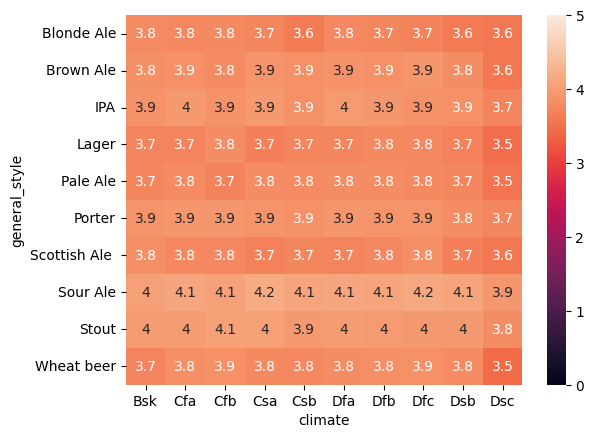

In [20]:
# heatmap of the ratings given to each beer type in each climate

df = pd.crosstab(climate_beer_type['general_style'],climate_beer_type['climate'],values=climate_beer_type['overall'],aggfunc='mean')

sns.heatmap(df, annot=True, vmin = 0, vmax = 5)

There doesn't seem to be a significant difference between the ratings between the climates. There do seem to be types of beers that are generally preffered than others. Let's try to analyse these results in a bit more detail to look for significant differences. For example, the Dsc climate seems to have the most variety in results so we can explore this one first.

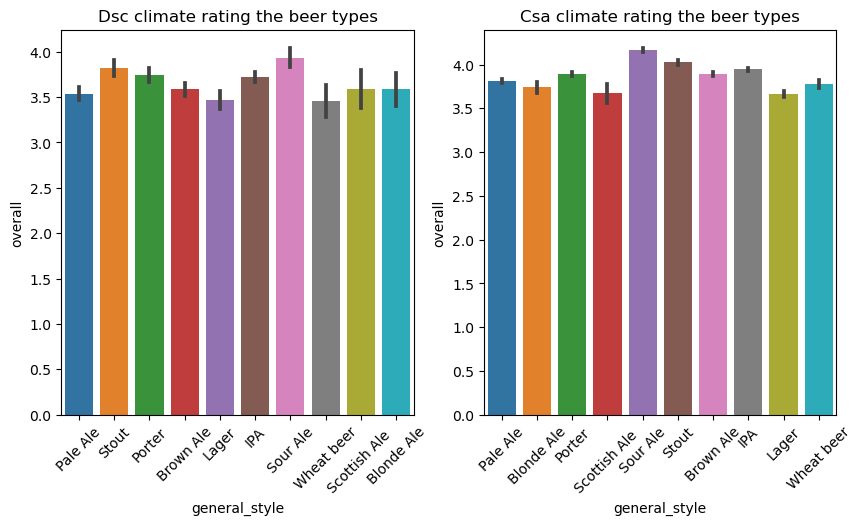

In [11]:
# view the average rating per beer type in Dsc and Csa

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,5))

plot_1 = sns.barplot(x='general_style', y='overall', data=us_users_ratings[us_users_ratings['climate']=='Dsc'], ax = ax0)
plot_1.set_xticklabels(plot_1.get_xticklabels(), rotation=45)
plot_1.set_title('Dsc climate rating the beer types')

plot_2 = sns.barplot(x='general_style', y='overall', data=us_users_ratings[us_users_ratings['climate']=='Csa'], ax = ax1)
plot_2.set_xticklabels(plot_2.get_xticklabels(), rotation=45)
plot_2.set_title('Csa climate rating the beer types')

plt.show()

In [24]:
# Let's try to do a chi2 test on overall score and general_style for reviews in Csa
# H0: the two variables are independent
# Repeat for all climates
data_to_test = us_users_ratings[us_users_ratings['climate']=='Csa'][['overall', 'general_style']]

# create a contingency table
contingency_table = pd.crosstab(data_to_test['overall'], data_to_test['general_style'])

# run the chi2 test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print("P-value is {}".format(p))

P-value is 2.6812929881196597e-235


In [27]:
# Microaverage: compute the mean overall rating for all users
micro_av_overall = us_users_ratings['overall'].mean()
print("The micro average overall rating is {:.4f}".format(micro_av_overall))

# Macroaverage: compute statistics for each climate, then take the mean
climate_av_overall = us_users_ratings.groupby("climate")['overall'].mean().sort_values(ascending=False).reset_index()
climate_av_overall.set_index("climate", inplace=True)
macro_av_overall = climate_av_overall['overall'].mean()
print("The macro average overall rating is {:.4f}".format(macro_av_overall))

The micro average overall rating is 3.8869
The macro average overall rating is 3.8470


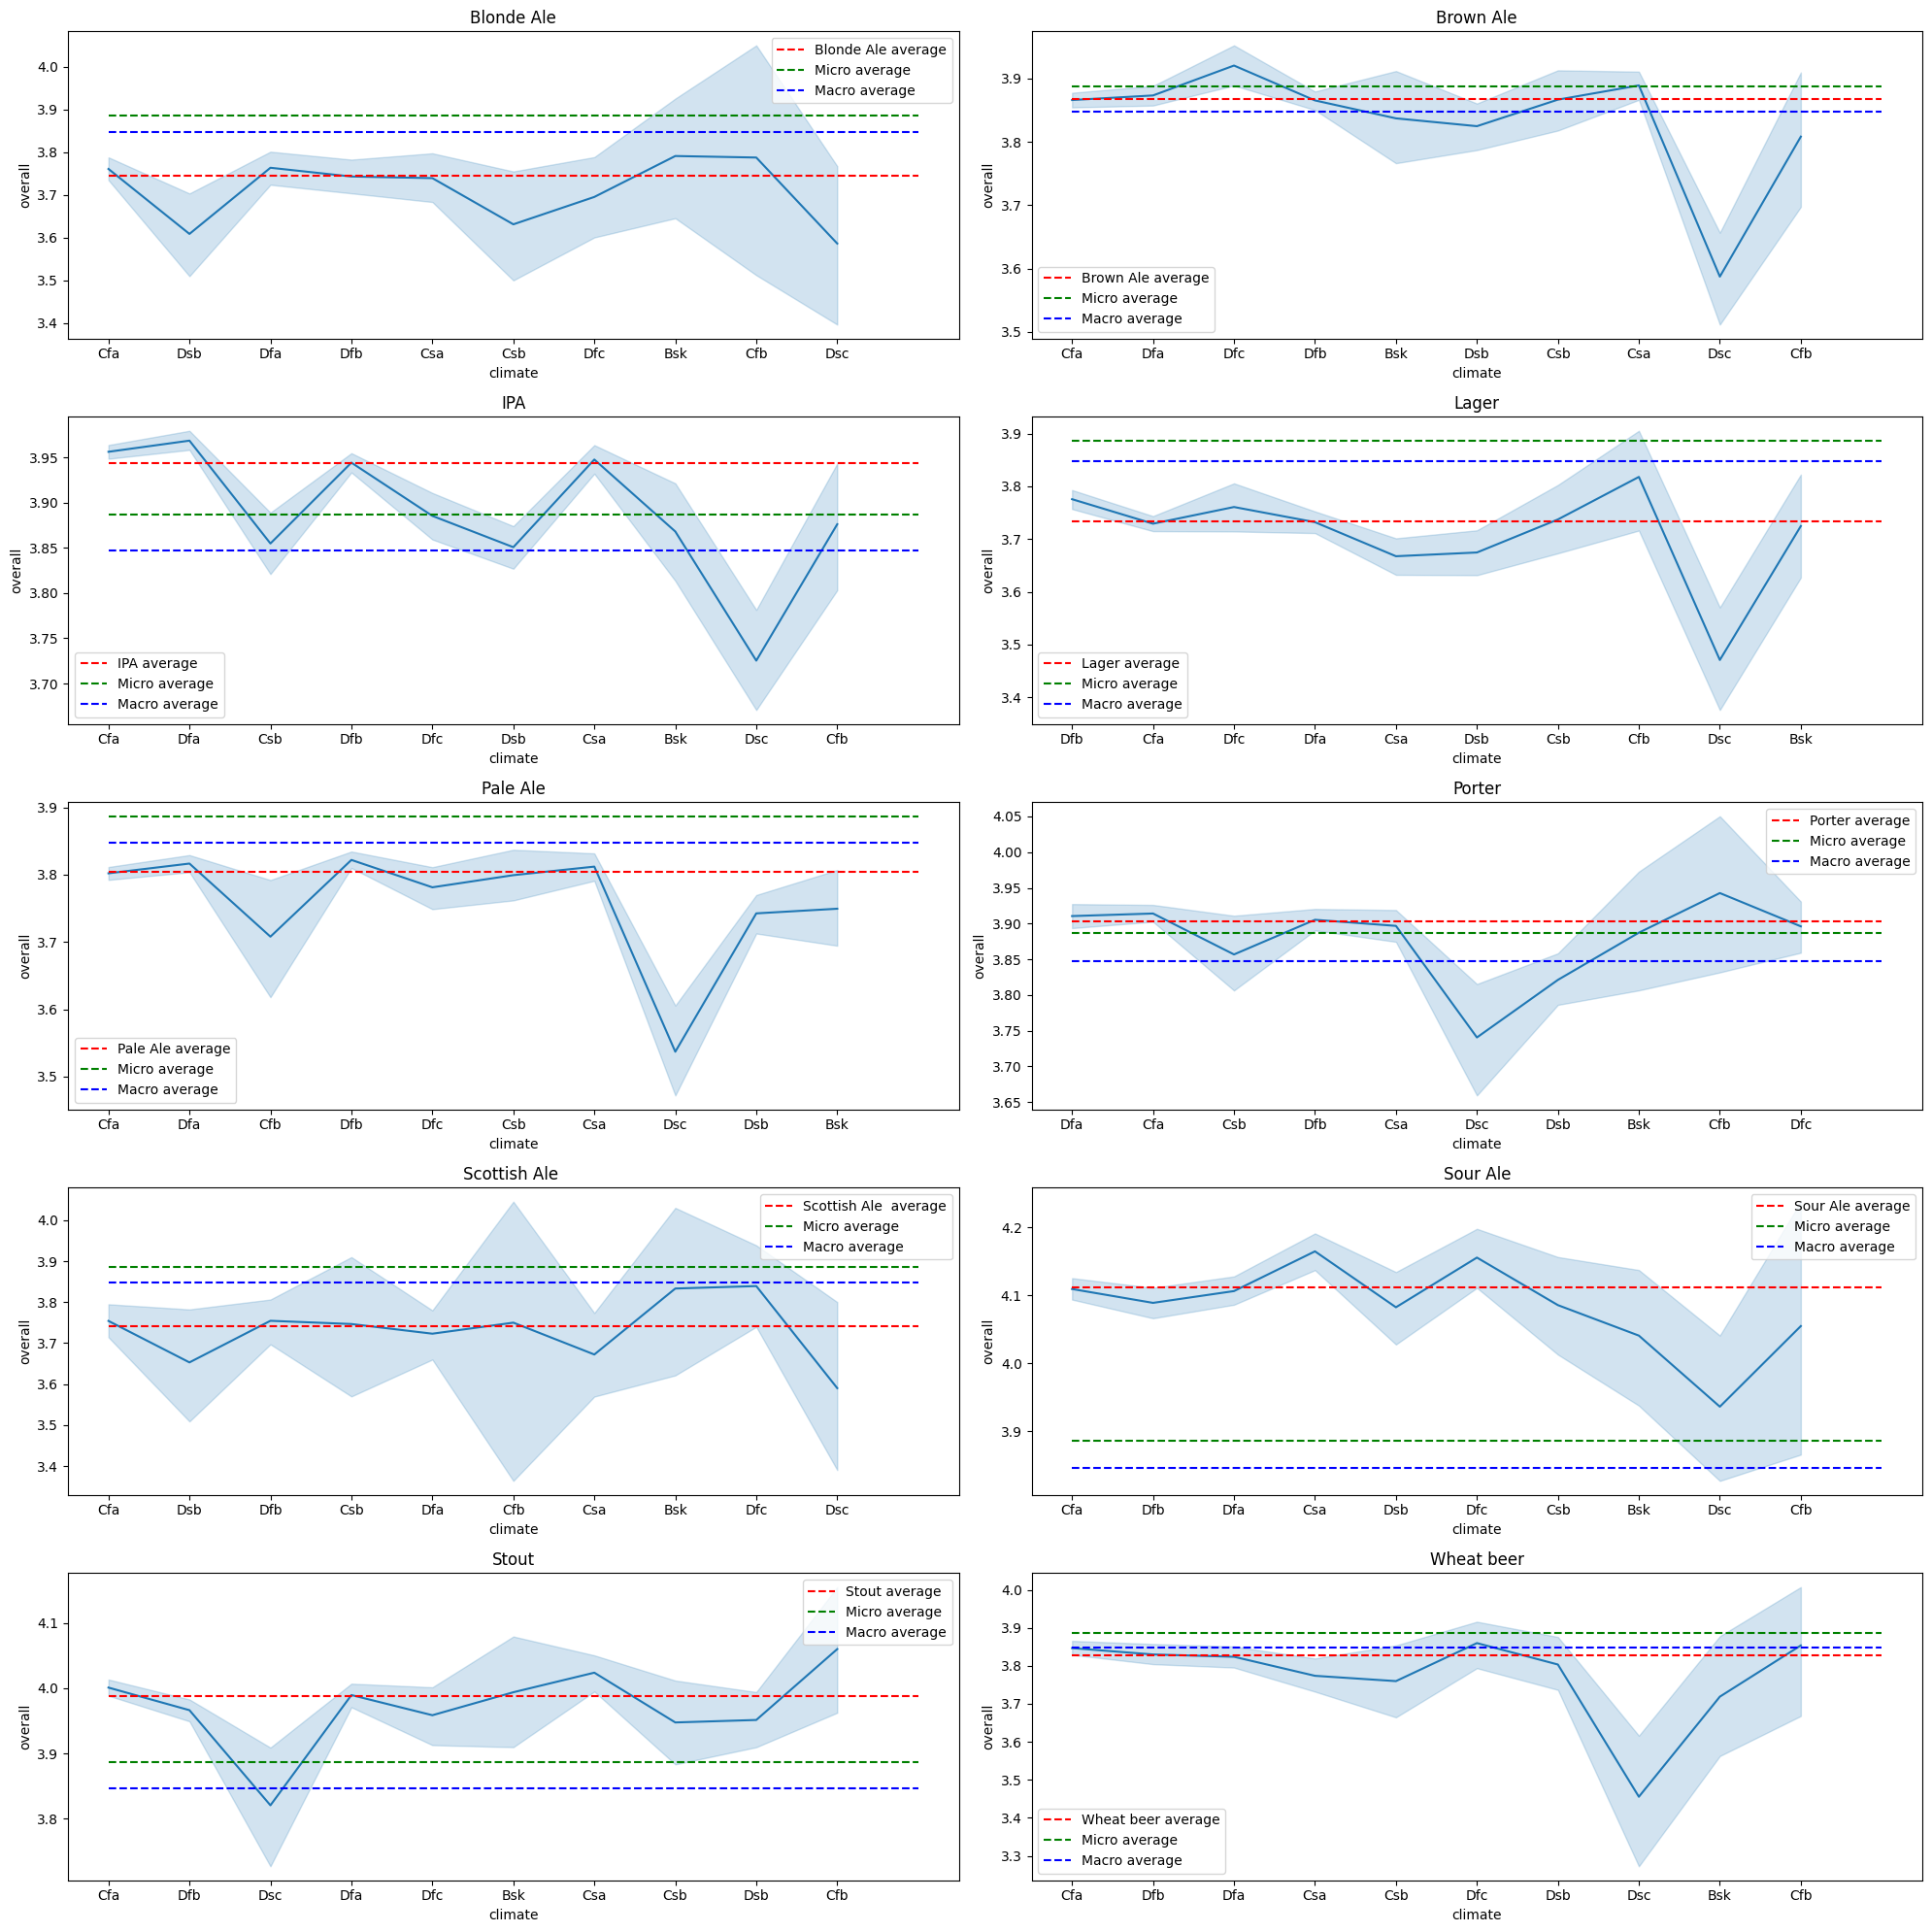

In [31]:
# Plot the different beer type means as a function of the climate for all beers

num_scores = len(climate_beer_type['climate'].unique())
fig, axs = plt.subplots(num_scores//2, 2, figsize=(20, 20))

for i, beer_type in enumerate(climate_beer_type['general_style'].unique()):

    # compute average beer rating for that beer type
    beer_type_av_overall = us_users_ratings[us_users_ratings['general_style']==beer_type]['overall'].mean()

    # plot the overall beer ratings for each type, climate and the different averagers
    ax = axs[i//2, i%2]
    sns.lineplot(x='climate', y='overall', data=us_users_ratings[us_users_ratings['general_style']==beer_type], ax=ax)
    ax.set_title(beer_type)
    ax.plot([0, num_scores], [beer_type_av_overall,beer_type_av_overall], "r--", label="{} average".format(beer_type))
    ax.plot([0, num_scores], [micro_av_overall,micro_av_overall], "g--", label="Micro average")
    ax.plot([0, num_scores], [macro_av_overall,macro_av_overall], "b--", label="Macro average")
    ax.legend()

plt.tight_layout()
plt.show()

The four different averages are:
- beer macro average: moyenne des averages par climat pour ce type de biere
- beer micro average: moyenne de tous les averages pour ce type de biere
- macro average: moyenne des averages par climat de toutes les bieres
- micro average: moyenne de tous les averages

It can be noted that the beer macro and micro averages are very similar for Wheat beer, Stout and Lager. This means that the average rating per climate is the same as the average rating overall ie. could be the same distribution or they compensate each other.

Furthermore, From these visualisations, the beers look to be in three main categories:
- beers that are rated better than the micro/macro averages (Stout, Sour Ale)
- beers that are rated better than the micro/macro averages (Wheat Beer,Lager, Blonde Ale, Scottish Ale, Pale Ale)
- beers with ratings that fluctuate around the micro/macro averages (Porter, IPA, Brown Ale)

In [56]:
#keep only the beers which have an abv between 0 and 95% (to remove outliers)
quantile_5 = us_users_ratings["abv"].quantile(0.05)
quantile_95 = us_users_ratings["abv"].quantile(0.95)

print("Shape before filtering:", us_users_ratings.shape)
us_abv_ratings = us_users_ratings[(us_users_ratings["abv"] > quantile_5) & (us_users_ratings["abv"] < quantile_95)]
print("Shape after filtering:", us_abv_ratings.shape)


Shape before filtering: (238407, 35)
Shape after filtering: (210158, 35)


In [57]:
# Can be useful
abv_averge_per_beer_type = us_abv_ratings.groupby(['general_style'])['abv'].mean().reset_index()
abv_averge_per_beer_type.head(10)

,general_style,abv
0,Blonde Ale,5.321819
1,Brown Ale,6.71369
2,IPA,7.409254
3,Lager,5.743549
4,Pale Ale,6.310136
5,Porter,8.039558
6,Scottish Ale,7.31165
7,Sour Ale,6.563896
8,Stout,8.345054
9,Wheat beer,5.992447


In [58]:
# Create a datafram which gives for each climate the general style ordered by the average overall rating
columns = ['climate'] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate = pd.DataFrame(columns=columns)

for climate in climate_beer_type['climate'].unique():
    best_beers_per_climate.loc[climate] = [climate] + list(climate_beer_type[climate_beer_type['climate']==climate].sort_values(by='overall', ascending=False)['general_style'].values[:10])
    
best_beers_per_climate.head(10)

,climate,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
Bsk,Bsk,Sour Ale,Stout,Porter,IPA,Brown Ale,Scottish Ale,Blonde Ale,Pale Ale,Lager,Wheat beer
Cfa,Cfa,Sour Ale,Stout,IPA,Porter,Brown Ale,Wheat beer,Pale Ale,Blonde Ale,Scottish Ale,Lager
Cfb,Cfb,Stout,Sour Ale,Porter,IPA,Wheat beer,Lager,Brown Ale,Blonde Ale,Scottish Ale,Pale Ale
Csa,Csa,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Wheat beer,Blonde Ale,Scottish Ale,Lager
Csb,Csb,Sour Ale,Stout,Brown Ale,Porter,IPA,Pale Ale,Wheat beer,Scottish Ale,Lager,Blonde Ale
Dfa,Dfa,Sour Ale,Stout,IPA,Porter,Brown Ale,Wheat beer,Pale Ale,Blonde Ale,Lager,Scottish Ale
Dfb,Dfb,Sour Ale,Stout,IPA,Porter,Brown Ale,Wheat beer,Pale Ale,Lager,Scottish Ale,Blonde Ale
Dfc,Dfc,Sour Ale,Stout,Brown Ale,Porter,IPA,Wheat beer,Scottish Ale,Pale Ale,Lager,Blonde Ale
Dsb,Dsb,Sour Ale,Stout,IPA,Brown Ale,Porter,Wheat beer,Pale Ale,Lager,Scottish Ale,Blonde Ale
Dsc,Dsc,Sour Ale,Stout,Porter,IPA,Scottish Ale,Brown Ale,Blonde Ale,Pale Ale,Lager,Wheat beer


In [59]:
# Can compute average position for each beer type in the top 10 for each climate
beers_average_position = {}

for row in best_beers_per_climate.iterrows():
   for i, beer in enumerate(row[1][1:]):
       if beer in beers_average_position:
           beers_average_position[beer] += (i+1)
       else:
           beers_average_position[beer] = (i+1)
           
for beer in beers_average_position:
    beers_average_position[beer] /= len(best_beers_per_climate)
    
print("The average position of each beer type in the top 10 for each climate is:")
print(beers_average_position)

The average position of each beer type in the top 10 for each climate is:
{'Sour Ale': 1.1, 'Stout': 1.9, 'Porter': 3.8, 'IPA': 3.7, 'Brown Ale': 4.8, 'Scottish Ale ': 8.1, 'Blonde Ale': 8.6, 'Pale Ale': 7.4, 'Lager': 8.7, 'Wheat beer': 6.9}


In [60]:
# Now let's analyse the scheme of the climate and the overall rating
columns = ['climate_scheme'] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate_scheme = pd.DataFrame(columns=columns)
amount_reviews_per_climate_scheme = pd.DataFrame(columns=columns)

for climate_scheme in us_abv_ratings['climate_scheme'].unique():
    row = [climate_scheme] + list(us_abv_ratings[us_abv_ratings['climate_scheme']==climate_scheme].groupby(['general_style'])['overall'].mean().sort_values(ascending=False).reset_index()['general_style'].values[:10])
    best_beers_per_climate_scheme.loc[len(best_beers_per_climate_scheme)] = row
    amount_reviews_per_climate_scheme.loc[len(amount_reviews_per_climate_scheme)] = [climate_scheme] + list(us_abv_ratings[us_abv_ratings['climate_scheme']==climate_scheme].groupby(['general_style'])['overall'].count().sort_values(ascending=False).reset_index()['overall'].values[:10])

display(best_beers_per_climate_scheme)
display(amount_reviews_per_climate_scheme)

,climate_scheme,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,Temperate,Sour Ale,IPA,Stout,Brown Ale,Porter,Wheat beer,Pale Ale,Scottish Ale,Lager,Blonde Ale
1,Continental,Sour Ale,IPA,Stout,Brown Ale,Porter,Wheat beer,Pale Ale,Lager,Scottish Ale,Blonde Ale
2,Dry,Sour Ale,Scottish Ale,IPA,Stout,Brown Ale,Porter,Pale Ale,Blonde Ale,Lager,Wheat beer


,climate_scheme,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,Temperate,29695,20166,12869,11380,9506,7572,5817,4852,1329,1099
1,Continental,29379,20007,13203,11140,9643,7906,5670,4401,1435,1051
2,Dry,561,420,239,209,173,153,128,85,35,32


In [61]:
# Now let's analyse the precipitation of the climate and the overall rating
columns = ['climate_precipitation'] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate_precipitation = pd.DataFrame(columns=columns)
amount_reviews_per_climate_precipitation = pd.DataFrame(columns=columns)

for climate_precipitation in us_abv_ratings['climate_precipitation'].unique():
    row = [climate_precipitation] + list(us_abv_ratings[us_abv_ratings['climate_precipitation']==climate_precipitation].groupby(['general_style'])['overall'].mean().sort_values(ascending=False).reset_index()['general_style'].values[:10])
    best_beers_per_climate_precipitation.loc[len(best_beers_per_climate_precipitation)] = row
    amount_reviews_per_climate_precipitation.loc[len(amount_reviews_per_climate_precipitation)] = [climate_precipitation] + list(us_abv_ratings[us_abv_ratings['climate_precipitation']==climate_precipitation].groupby(['general_style'])['overall'].count().sort_values(ascending=False).reset_index()['overall'].values[:10])
    
display(best_beers_per_climate_precipitation)
display(amount_reviews_per_climate_precipitation)

,climate_precipitation,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,without dry season,Sour Ale,IPA,Stout,Brown Ale,Porter,Wheat beer,Pale Ale,Scottish Ale,Lager,Blonde Ale
1,with dry season,Sour Ale,IPA,Stout,Brown Ale,Porter,Pale Ale,Wheat beer,Scottish Ale,Lager,Blonde Ale


,climate_precipitation,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,without dry season,48915,33445,21632,18745,16600,13342,8974,7944,2361,1798
1,with dry season,10720,7148,4679,3984,2722,2641,2289,1394,438,384


In [62]:
# Now let's analyse the temperature of the climate and the overall rating
columns = ['climate_temperature'] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate_temperature = pd.DataFrame(columns=columns)
amount_reviews_per_climate_temperature = pd.DataFrame(columns=columns)

for climate_temperature in us_abv_ratings['climate_temperature'].unique():
    row = [climate_temperature] + list(us_abv_ratings[us_abv_ratings['climate_temperature']==climate_temperature].groupby(['general_style'])['overall'].mean().sort_values(ascending=False).reset_index()['general_style'].values[:10])
    best_beers_per_climate_temperature.loc[len(best_beers_per_climate_temperature)] = row
    amount_reviews_per_climate_temperature.loc[len(amount_reviews_per_climate_temperature)] = [climate_temperature] + list(us_abv_ratings[us_abv_ratings['climate_temperature']==climate_temperature].groupby(['general_style'])['overall'].count().sort_values(ascending=False).reset_index()['overall'].values[:10])
    
display(best_beers_per_climate_temperature)
display(amount_reviews_per_climate_temperature)

,climate_temperature,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,hot summer,Sour Ale,IPA,Stout,Brown Ale,Porter,Wheat beer,Pale Ale,Scottish Ale,Lager,Blonde Ale
1,warm summer,Sour Ale,IPA,Stout,Brown Ale,Porter,Wheat beer,Pale Ale,Lager,Scottish Ale,Blonde Ale
2,cold summer,Sour Ale,Brown Ale,IPA,Stout,Porter,Scottish Ale,Wheat beer,Pale Ale,Lager,Blonde Ale


,climate_temperature,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,hot summer,39863,26688,17216,14974,12864,10509,7951,6362,1823,1401
1,warm summer,16858,11895,7717,6611,5574,4382,2987,2500,813,633
2,cold summer,2914,2010,1378,1144,884,740,677,476,163,148


In [ ]:
# For each of the previous three analysis, select one sub-category (e.g. climate scheme: Temperate), compute chi2 between overall and general_style